In [9]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rn
import random
import cv2
import math
import os
import glob

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# Set seed for reproducibility
def set_seeds(seed=3888):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    rn.seed(seed)

# Define function to print out classification metrics for deep learning models
def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

## Background Research
[Roboflow Universe](https://universe.roboflow.com/ali-rostami/labeled-mri-brain-tumor-dataset/dataset/1) is a large repository containing labeled MRI brain tumour datasets. This specific [dataset from Kaggle](https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/data)

There were three different Kaggle datasets identified for labelled MRI brain tumour scans:
- [Dataset 1:](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?select=Training) Contains 7023 images of human brain MRI images classified into four classes: glioma, meningioma, pituitary and no tumour.
- [Dataset 2](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) Contains 3264 images of human brain MRI images classified into four classes: glioma, meningioma, pituitary and no tumour
- [Dataset 3](https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection/data) Contains 3903 of human brain MRI images categorised into four classes: glioma, meningioma, pituitary and no tumour. Kaggle dataset removes no tumour classes and so only 2144 images are left. Probably won't use this dataset.

## Data loading - dataset 1

In [66]:
for class_name, class_id in class_to_id.items():
    print(class_name, class_id)

notumor 0
glioma 1
meningioma 2
pituitary 3


In [72]:
train_path = 'data/Training'
test_path = 'data/Testing'

class_to_id = {"notumor": 0, "glioma": 1, "meningioma": 2, "pituitary": 3}

def load_data(path, img_size=224):
    """
    Return X, y matrices given directory path
    """
    images, labels = [], []
    for class_name, class_id in class_to_id.items():
        img_dir = os.path.join(path, class_name)
        
        for img_path in glob.glob(os.path.join(img_dir, "*.*")):
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)

            images.append(img)
            labels.append(class_id)

    X = np.stack(images).astype("float32") / 255.0
    y = np.array(labels, dtype=np.int64)

    return X, y

X_train, y_train = load_data(train_path, img_size=224)
X_test, y_test = load_data(test_path, img_size=224)

### Distribution of classes

In [90]:
np.unique(y_train, return_counts=True)

array([0, 1, 2, 3])

In [94]:
class_labels = ['notumor', 'glioma', 'meningioma', 'pituitary']
# Computing train counts
train_counts = np.unique(y_train, return_counts=True)[1]
train_counts_df = pd.DataFrame({'Class': class_labels, 'Count': train_counts})

# Computing test counts
test_counts = np.unique(y_test, return_counts=True)[1]
test_counts_df = pd.DataFrame({'Class': class_labels, 'Count': test_counts})

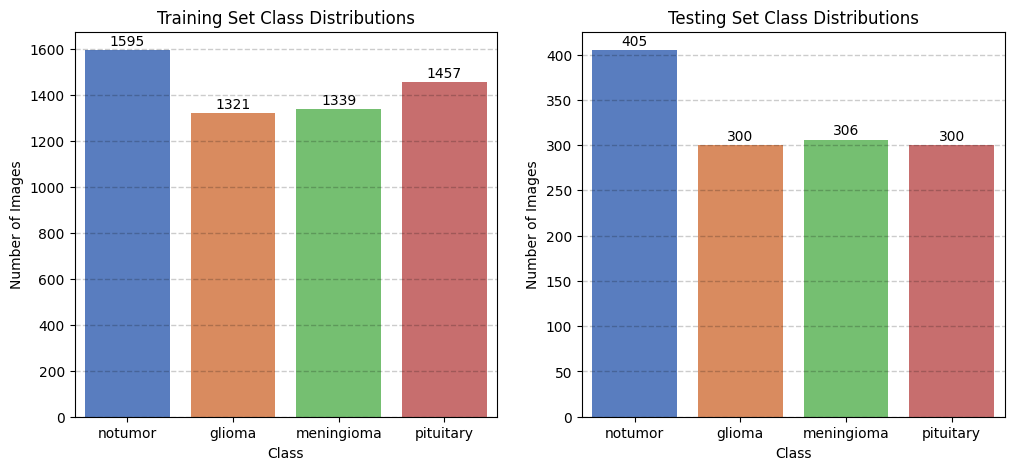

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
# Plot 1: Training Set Class Distributions
sns.barplot(data=train_counts_df, x='Class', y='Count', ax=axes[0], hue='Class', palette='muted')
axes[0].set_title("Training Set Class Distributions")
axes[0].set_xlabel("Class"); axes[0].set_ylabel("Number of Images")
axes[0].grid(which='major', axis='y', linestyle='--', linewidth=1, color='black', alpha=0.2)

# Annotate bars
for p in axes[0].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[0].text(x, y + max(train_counts) * 0.005, int(y), ha='center', va='bottom')

# Plot 2: Training Set Class Distributions
sns.barplot(data=test_counts_df, x='Class', y='Count', ax=axes[1], hue='Class', palette='muted')
axes[1].set_title("Testing Set Class Distributions")
axes[1].set_xlabel("Class"); axes[1].set_ylabel("Number of Images")
axes[1].grid(which='major', axis='y', linestyle='--', linewidth=1, color='black', alpha=0.2)

# Annotate bars
for p in axes[1].patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    axes[1].text(x, y + max(test_counts) * 0.005, int(y), ha='center', va='bottom')

### Visualising images

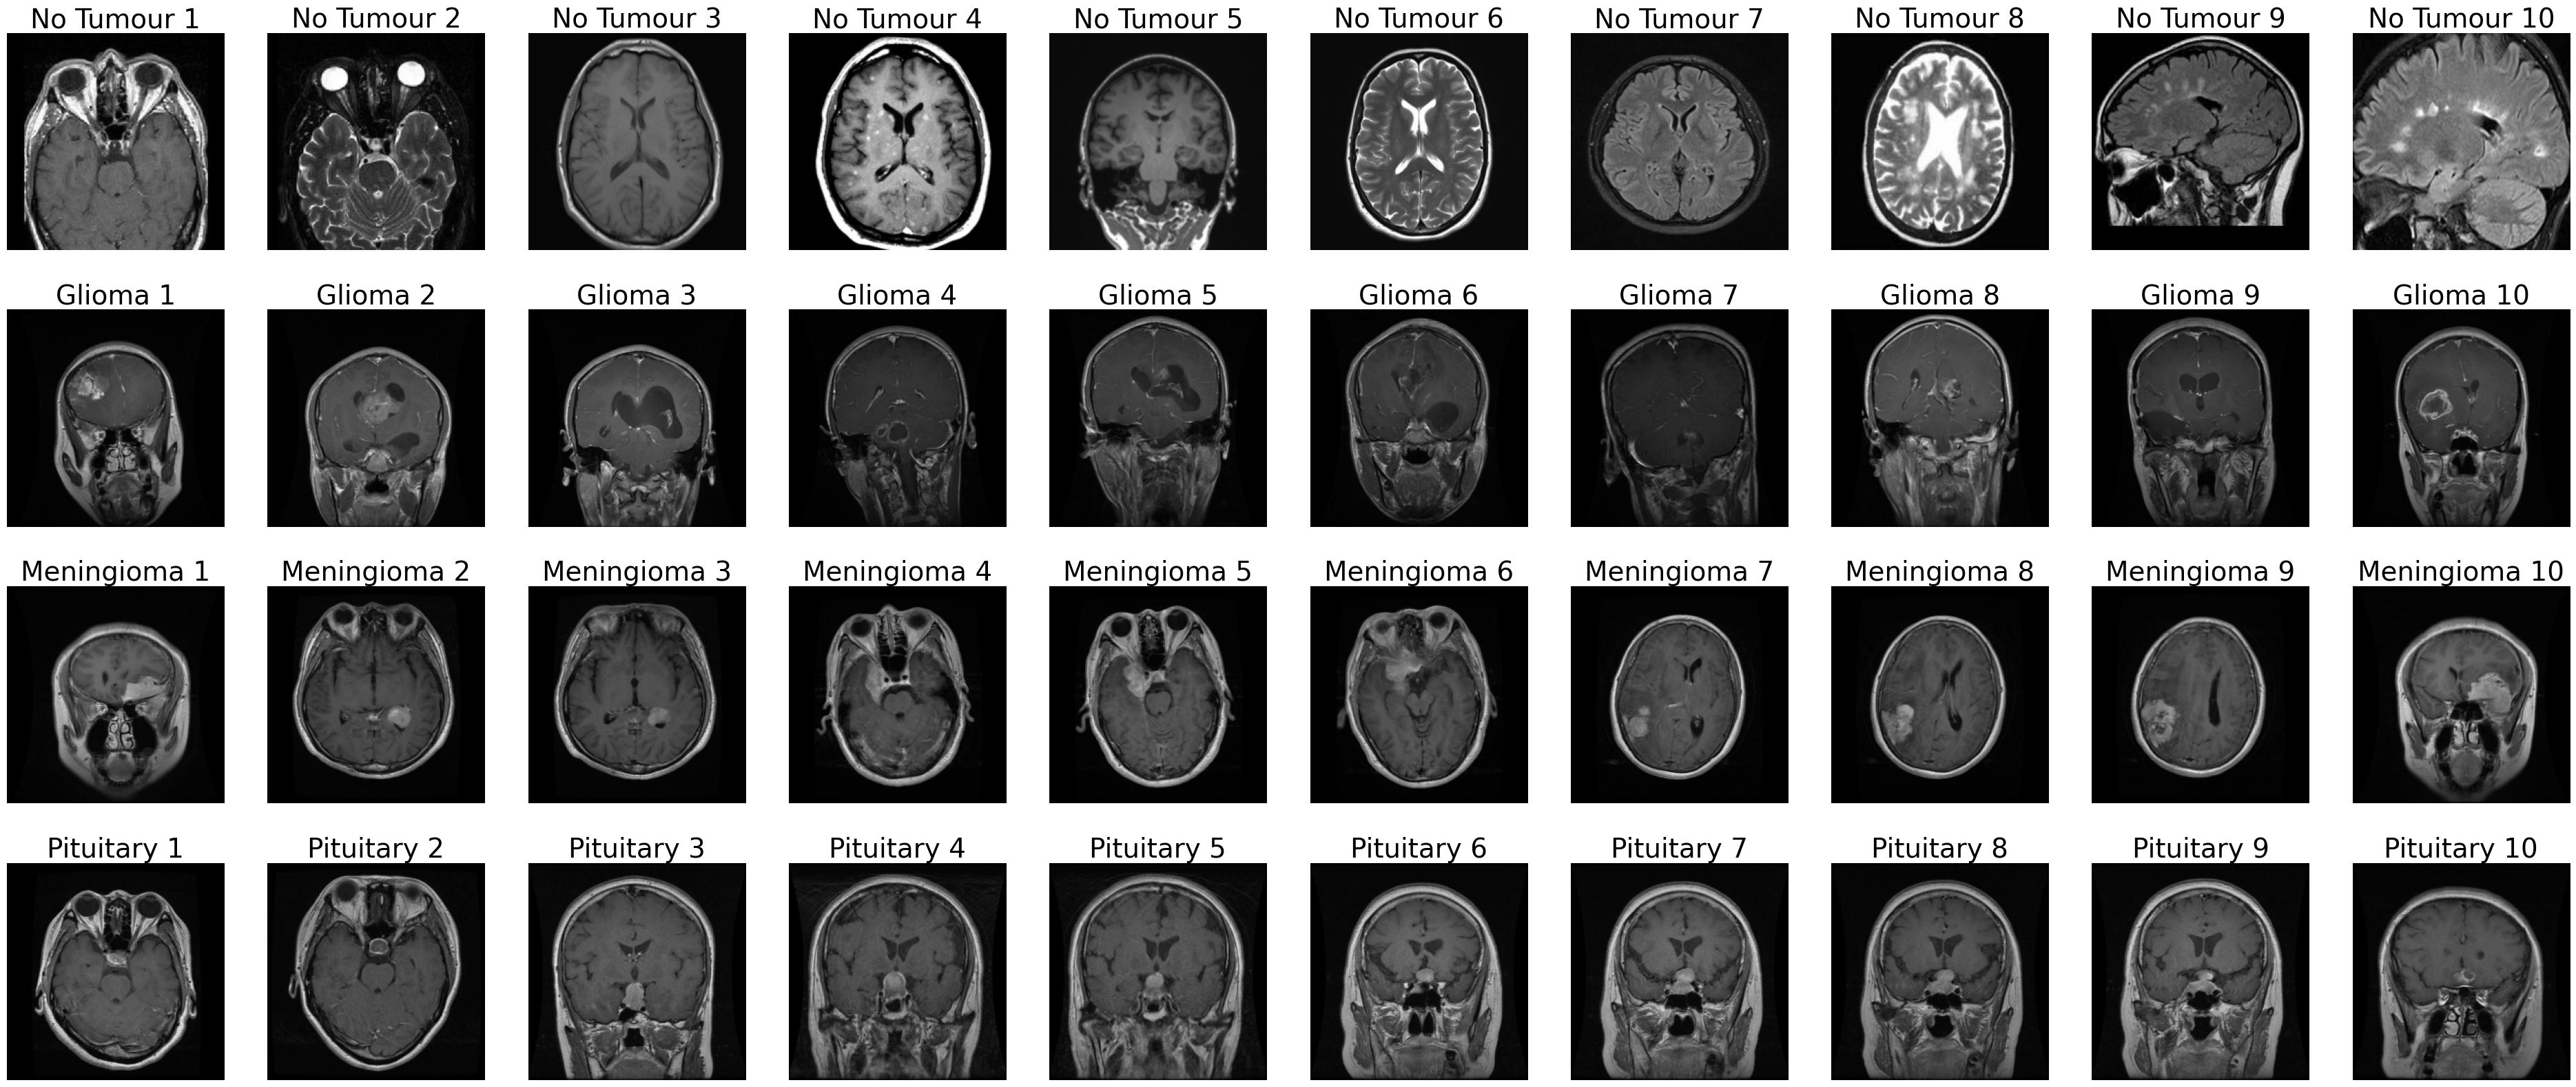

In [142]:
# Plot first few images of each class in training data
fig, axes = plt.subplots(4, 10, figsize=(48,20))
i, num_imgs = 0, 0
for i in range(len(X_train)):
    img = X_train[i]
    img_label = y_train[i]
    # Check if image is no tumour (class = 0)
    if img_label == 0:
        axes[0,num_imgs].imshow(img)
        axes[0,num_imgs].set_axis_off()
        axes[0,num_imgs].set_title(f"No Tumour {num_imgs+1}", fontsize=28)
        num_imgs += 1
    if num_imgs == 10:
        break

i, num_imgs = 0, 0
for i in range(len(X_train)):
    img = X_train[i]
    img_label = y_train[i]
    # Check if image is glioma (class = 1)
    if img_label == 1:
        axes[1,num_imgs].imshow(img)
        axes[1,num_imgs].set_axis_off()
        axes[1,num_imgs].set_title(f"Glioma {num_imgs+1}", fontsize=28)
        num_imgs += 1
    if num_imgs == 10:
        break

i, num_imgs = 0, 0
for i in range(len(X_train)):
    img = X_train[i]
    img_label = y_train[i]
    # Check if image is meningioma (class = 2)
    if img_label == 2:
        axes[2,num_imgs].imshow(img)
        axes[2,num_imgs].set_axis_off()
        axes[2,num_imgs].set_title(f"Meningioma {num_imgs+1}", fontsize=28)
        num_imgs += 1
    if num_imgs == 10:
        break

i, num_imgs = 0, 0
for i in range(len(X_train)):
    img = X_train[i]
    img_label = y_train[i]
    # Check if image is pituitary (class = 3)
    if img_label == 3:
        axes[3,num_imgs].imshow(img)
        axes[3,num_imgs].set_axis_off()
        axes[3,num_imgs].set_title(f"Pituitary {num_imgs+1}", fontsize=28)
        num_imgs += 1
    if num_imgs == 10:
        break

### Data loading - dataset 3
Missing no tumour class so probably won't use

In [37]:
# # Data loading code for dataset 3 - missing no tumour class so probably won't use
# train_path = 'data3/BrainTumorYolov11/train'
# val_path = 'data3/BrainTumorYolov11/valid'
# test_path = 'data3/BrainTumorYolov11/test'

# def load_data(path, img_size=224):
#     """
#     Return X, y matrices given directory path
#     """
#     img_dir = os.path.join(path, "images")
#     label_dir = os.path.join(path, "labels")

#     images, labels = [], []

#     for img_path in sorted(glob.glob(os.path.join(img_dir, "*.jpg"))):
#         # Load images
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.resize(img, (img_size, img_size))
#         images.append(img)

#         # Load labels
#         base = os.path.splitext(os.path.basename(img_path))[0]
#         txt = os.path.join(label_dir, base + ".txt")
#         with open(txt) as f:
#             line_ls = f.readline().split()
#             class_id = int(line_ls[0])
#         labels.append(class_id)

#     X = np.stack(images).astype("float32") / 255.0
#     y = np.array(labels, dtype=np.int64)

#     return X, y

# X_train, y_train = load_data(train_path)
# X_val, y_val = load_data(val_path)
# X_test, y_test = load_data(test_path)

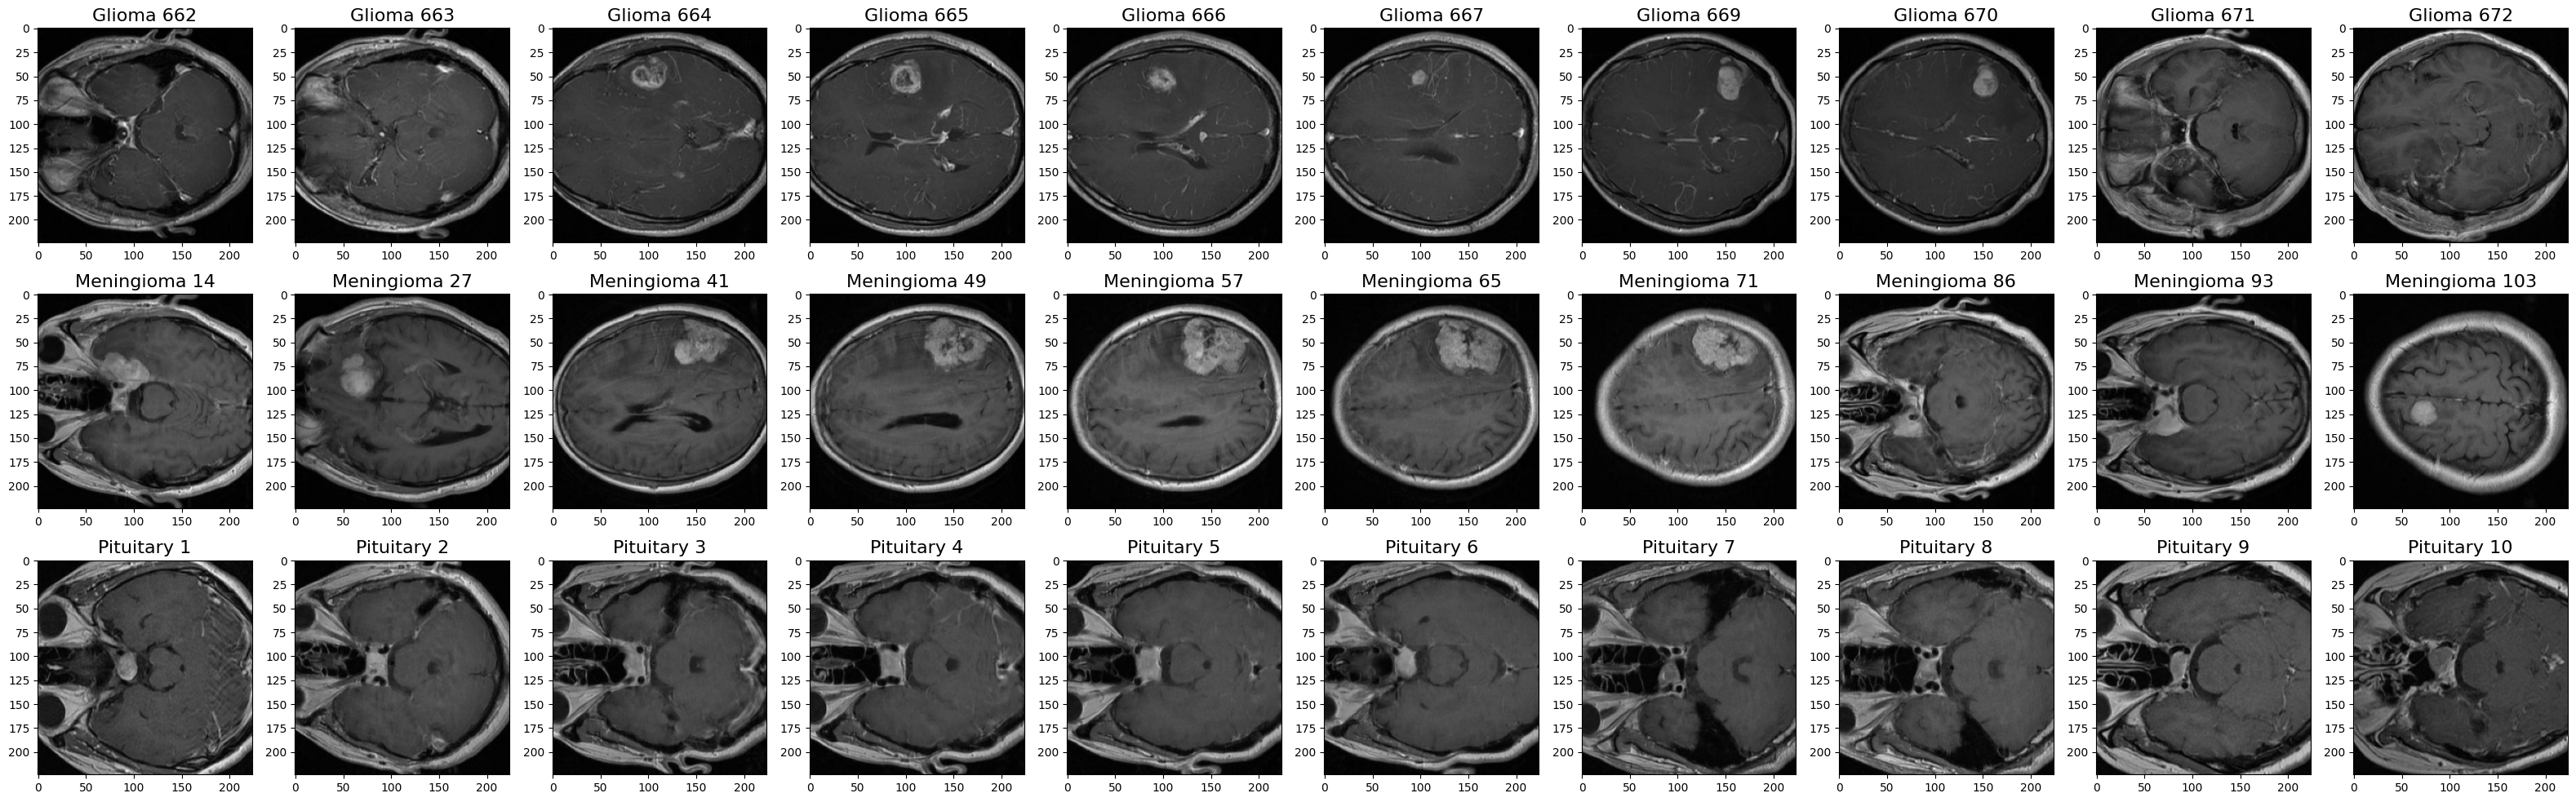

In [60]:
# # Plot first few images of each class in training data
# fig, axes = plt.subplots(3, 10, figsize=(40,12))
# i, num_imgs = 0, 0
# for i in range(len(X_train)):
#     img = X_train[i]
#     img_label = y_train[i]
#     # Check if image is glioma (class = 0)
#     if img_label == 0:
#         axes[0,num_imgs].imshow(img)
#         axes[0,num_imgs].set_title(f"Glioma {i+1}", fontsize=16)
#         num_imgs += 1
#     if num_imgs == 10:
#         break

# i, num_imgs = 0, 0
# for i in range(len(X_train)):
#     img = X_train[i]
#     img_label = y_train[i]
#     # Check if image is meningioma (class = 1)
#     if img_label == 1:
#         axes[1,num_imgs].imshow(img)
#         axes[1,num_imgs].set_title(f"Meningioma {i+1}", fontsize=16)
#         num_imgs += 1
#     if num_imgs == 10:
#         break

# i, num_imgs = 0, 0
# for i in range(len(X_train)):
#     img = X_train[i]
#     img_label = y_train[i]
#     # Check if image is pituitary (class = 2)
#     if img_label == 2:
#         axes[2,num_imgs].imshow(img)
#         axes[2,num_imgs].set_title(f"Pituitary {i+1}", fontsize=16)
#         num_imgs += 1
#     if num_imgs == 10:
#         break

## Model Development